# NumPyroを使用したベイズ回帰
https://nbviewer.jupyter.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb

## NumPyroでMCMCを使用して、特にNo U-Turn Sampler（NUTS）を使用して推論を実行し、対象の回帰パラメーターの事後分布を取得する

NUTS(No-U-Turn Sampler): MCMC（マルコフ連鎖モンテカルロ法）の方法.Metropolis法の発展であるHMC(Hamiltonian Monte Carlo)の拡張手法
https://lib-arts.hatenablog.com/entry/NUTS1


ハミルトニアンモンテカルロ (HMC)はパラメータの勾配を利用して， 効率的にMCMCサンプリングを行うことができる手法

HMCの問題点は2つ．

- 更新ステップ数 Lを適切に指定しなければいけない．
- 更新の大きさ ϵ を適切に指定しなければいけない．

NUTSは更新ステップ数Lを自動的に決定する手法

ハミルトニアンモンテカルロでは,正規分布によって発生させた運動量を与えて， Lステップの間，点を動かす． 予め決められたLステップの間，点を動かすので，例えば谷にハマった時などガタガタして無駄な計算をしてしまう．

NUTSでは「Uターンしたら点を動かすのをやめる」という規則でこの無駄な計算をなくす． ただし，単純にUターンしたときに中断したら詳細釣り合い条件を満たさなくなるので，少し工夫する．


- https://ksknw.hatenablog.com/entry/2017/08/06/185553

In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.6.0')

In [2]:
# GPUだとMCMC遅いのでcpu使う
numpyro.set_platform("cpu")

### Dataset
この例ではWaffleDivorce、第05章「統計的再考[ 1 ]」のデータセットを使用します。

データセットには、人口、結婚年齢の中央値、南部の州かどうか、不思議なことにワッフルハウスの数などの予測因子とともに、米国の50州のそれぞれの離婚率が含まれています。

In [3]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


データセット内の主要な変数間のペアワイズ関係をプロット

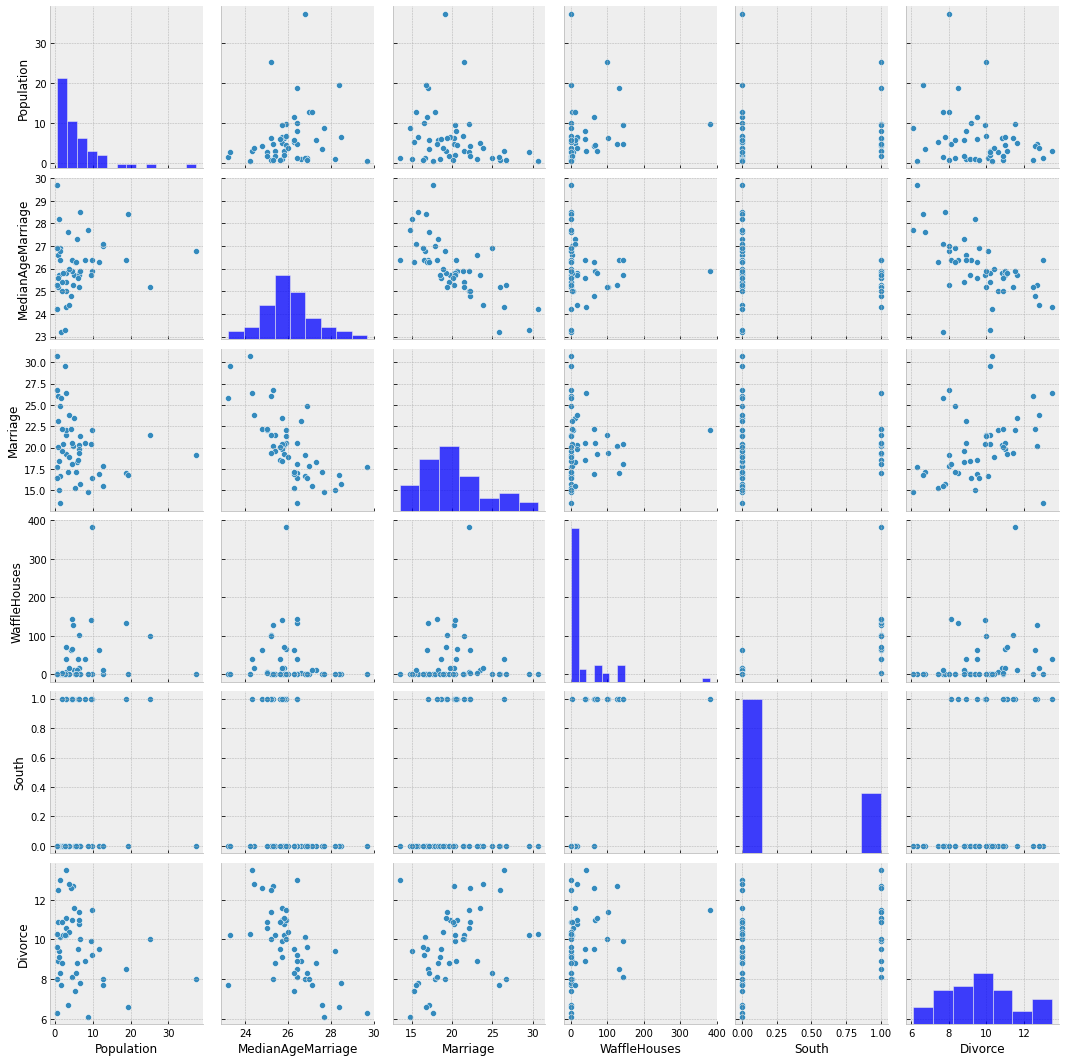

In [4]:
vars = ['Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South', 'Divorce']
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette='husl')

上記のプロットから、ある州の離婚率と結婚率の間には関係があり（予想されるように）、離婚率と結婚年齢の中央値の間にも関係があることがはっきりとわかります。

ワッフルハウスの数と離婚率の間にも弱い関係があります。これは上記のプロットからは明らかではありませんが、回帰DivorceしWaffleHouseて結果をプロットするとより明確になります。

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WaffleHouses', ylabel='Divorce'>

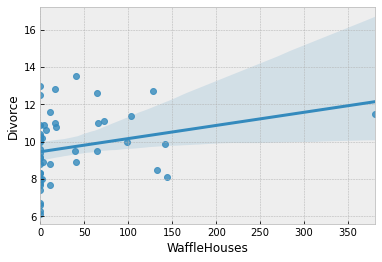

In [5]:
sns.regplot('WaffleHouses', 'Divorce', dset)

これは、疑似相関の例です。州内のワッフルハウスの数が離婚率に影響を与えるとは予想していませんが、離婚率に影響を与える他の要因と相関している可能性があります。このチュートリアルではこの疑似相関について詳しく説明しませんが、興味のある読者は、複数の予測子が存在する場合の因果関係の問題を探る[ 1 ]の第5章と第6章を読むことをお勧めします。

簡単にするために、残りのチュートリアル全体で離婚率の予測因子として、主に結婚率と結婚年齢の中央値に焦点を当てます。

### 離婚率を予測するための回帰モデル

ここで、NumPyroで回帰モデルを作成して、各州の結婚率と結婚年齢の中央値の線形関数として離婚率を予測しましょう。

まず、予測変数のスケールが多少異なることに注意してください。予測変数と応答変数を平均0と標準偏差1に標準化することをお勧めします。これにより、推論が高速化されます。

In [6]:
standardize = lambda x: (x - x.mean()) / x.std()

dset['AgeScaled'] = dset.MedianAgeMarriage.pipe(standardize)
dset['MarriageScaled'] = dset.Marriage.pipe(standardize)
dset['DivorceScaled'] = dset.Divorce.pipe(standardize)

NumPyroモデルは次のように記述します。コードは主に自明である必要がありますが、次の点に注意してください。

- NumPyroでは、モデルコードはPythonで呼び出し可能であり、オプションで追加の引数とキーワードを受け入れることができます。このチュートリアルで使用するHMCの場合、これらの引数とキーワードは推論中は静的なままですが、同じモデルを再利用して新しいデータの予測を生成できます。
- 通常のPythonステートメントに加えて、モデルコードにはsample。のようなプリミティブも含まれています。これらのプリミティブは、エフェクトハンドラーを使用してさまざまな副作用で解釈できます。エフェクトハンドラーの詳細については、[ 3 ]、[ 4 ]を参照してください。今のところ、sampleステートメントがこれを確率関数にして、事前分布からいくつかの潜在的なパラメーターをサンプリングすることを覚えておいてください。私たちの目標は、観測データを条件としてこれらのパラメーターの事後分布を推測することです。
- 予測子をオプションのキーワード引数として保持している理由は、予測子のセットを変更するときに同じモデルを再利用できるようにするためです。同様に、応答変数がオプションである理由は、このモデルを再利用して事後予測分布からサンプリングしたいためです。例として、事後予測分布のプロットに関するセクションを参照してください。

In [7]:
def model(marriage=None, age=None, divorce=None):
    "Normal(mu,sigma)の事後分布を仮定して、ガウス分布の平均を任意の確率分布で与える"
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    M, A = 0., 0.
    if marriage is not None:
        bM = numpyro.sample('bM', dist.Normal(0., 0.5))  # 事前分布
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0., 0.5))  # 事前分布
        A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))  # 事後分布の分散
    mu = a + M + A  # 
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

#### モデル1：予測子-結婚率
まず、離婚率を単一の変数である結婚率に依存するものとしてモデル化しようとします。

上記のように、model前と同じコードを使用できますがmarriage、divorceキーワード引数の値とキーワード引数のみを渡します。

この単純なモデルで推論を実行するために、No U-Turn Sampler（NUTSアルゴリズムの詳細については[ 5 ]を参照）を使用します。

NumPyroでのハミルトニアンモンテカルロ（またはNUTS）の実装は、位置エネルギー関数を取り入れます。

これは、モデルの負の対数同時密度です。
したがって、上記のモデルの説明では、パラメーター値を指定して位置エネルギー（または負の対数同時密度）を返す関数を作成する必要があります。
さらに、HMC（またはNUTS）のベレ積分器は、制約のない空間でハミルトニアンダイナミクスを使用してシミュレートされたサンプル値を返します。
そのため、サポートが制限された連続変数は、全単射変換を使用して制約のない空間に変換する必要があります。
また、これらの値をユーザーに返す前に、これらのサンプルを制約付きサポートに戻す必要があります。
ありがたいことに、これは、MCMC推論を行うための便利なクラス内で、バックエンドで処理されます。 次の方法があります。

- run(...)：ウォームアップを実行し、ステップサイズと質量行列を調整し、ウォームアップフェーズのサンプルを使用してサンプリングを行います。
- print_summary()：分位数、有効なサンプルサイズ、Gelman-Rubin診断などの診断情報を出力します。
- get_samples()：事後分布からサンプルを取得します。

次の点に注意してください。

- JAXは機能的なPRNGを使用します。グローバルなランダム状態を維持する他の言語/フレームワークとは異なり、JAXでは、サンプラーを呼び出すたびに明示的なPRNGKeyが必要です。同じシードを誤って再利用しないように、最初のランダムシードを後続の操作のために分割します。
- NUTSサンプラーで推論を実行します。バニラHMCを実行するには、代わりにHMCクラスを使用できます。

In [8]:
# このランダム性の源からスタートします。その後の操作のためにキーを分割します。
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values)

mcmc.print_summary()

samples_1 = mcmc.get_samples()

sample: 100%|██████████████████████████████████████| 3000/3000 [00:02<00:00, 1415.94it/s, 3 steps of size 7.62e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.01     -0.18      0.19   1417.02      1.00
        bM      0.35      0.13      0.35      0.13      0.55   2001.18      1.00
     sigma      0.95      0.10      0.94      0.78      1.10   1773.87      1.00

Number of divergences: 0


#### 回帰パラメーターの事後分布

プログレスバーには、NUTSの実行中にサンプルごとに実行された受け入れ確率、ステップサイズ、およびステップ数に関するオンライン統計が表示されます。

特に、ウォームアップ中に、ステップサイズと質量行列を調整して、デフォルトで0.8である特定のターゲット受け入れ確率を達成します。

ウォームアップフェーズでこの目標を達成するために、ステップサイズをうまく適応させることができました。

ウォームアップ中の目的は、ステップサイズや質量行列などのハイパーパラメーターを適応させ（HMCアルゴリズムはこれらのハイパーパラメーターに非常に敏感です）、一般的なセットに到達することです（詳細については[ 6 ]を参照）。

モデルの仕様に問題がある場合、最初に気付くシグナルは、受け入れ確率が低いか、ステップ数が非常に多いことです。

ウォームアップフェーズの終わりからのサンプルを使用して、MCMCチェーン（2番目のsampleプログレスバーで示される）をシードし、そこからターゲット分布から必要な数のサンプルを生成します。

推論の最後に、NumPyroは、各潜在パラメーターの平均、標準、および90％CI値を出力します。

予測変数と応答変数を標準化したため、ここに示すように、切片の平均が0になると予想されることに注意してください。

また、有効なサンプルサイズやゲルマンルービン診断（R^）。これらの診断の値は、チェーンがターゲット分布に収束したことを示します。

私たちの場合、「ターゲット分布」は、関心のある潜在パラメータの事後分布です。これは、より複雑なモデルの場合、複数のチェーンで検証する価値があることが多いことに注意してください。

最後に、samples_1（我々の場合では、コレクションであるdictのでinit_samplesたdictモデルにおける潜在各パラメータの事後分布からサンプルを含みます）。

回帰当てはめを確認するために、回帰パラメーターの事後推定と90％信頼区間（CI）を使用して回帰直線をプロットしましょう。

NumPyroの診断モジュールのhpdi関数を使用してCIを計算できることに注意してください。以下の関数では、後方から収集されたサンプルがすべて主軸に沿っていることに注意してください。

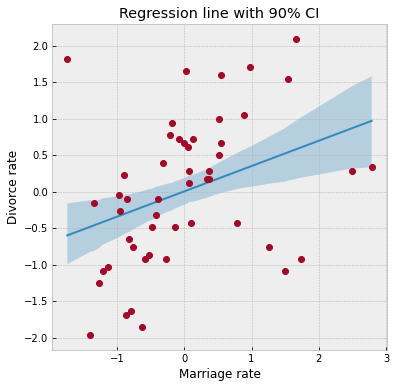

In [9]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1['a'], -1) + \
               jnp.expand_dims(samples_1['bM'], -1) * dset.MarriageScaled.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

プロットから、予想どおり、CIがデータが比較的まばらなテールに向かって広がっていることがわかります。

### 事後予測分布
ここで、事後予測分布を見て、観測された離婚率に関して予測分布がどのように見えるかを確認しましょう。

事後予測分布からサンプルを取得するには、潜在パラメーターを事後からのサンプルに置き換えてモデルを実行する必要があります。

NumPyroは、この目的のための便利な予測ユーティリティを提供します。デフォルトでは、結合事後分布からサンプルごとに1つの予測を生成しますが、これはnum_samples引数を使用して制御できることに注意してください。

In [10]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)['obs']
df = dset.filter(['Location'])
df['Mean Predictions'] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.009576
1,Alaska,0.556660
2,Arizona,0.014279
3,Arkansas,0.540481
4,California,-0.074709


エフェクトハンドラーを使用した予測ユーティリティ

背後Predictiveにある魔法を取り除くために、エフェクトハンドラーをvmap JAXプリミティブと組み合わせて、ベクトル化された予測を実行できる独自の簡略化された予測ユーティリティ関数を実装する方法を見てみましょう。

In [11]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace['obs']['value']

# vectorize predictions via vmap
predict_fn = vmap(lambda rng_key, samples: predict(rng_key, samples, model, marriage=dset.MarriageScaled.values))

関数でのcondition、seedおよびtraceエフェクトハンドラーの使用に注意してくださいpredict。

- seed効果・ハンドラは、最初に確率論的機能をラップするために使用されるPRNGKeyシード。モデル内のサンプルステートメントが呼び出されると、既存のシードを使用してディストリビューションからサンプリングしますが、このエフェクトハンドラーは既存のキーも分割sampleして、モデル内の今後の呼び出しで代わりに新しく分割されたキーが使用されるようにします。これは、モデル内のPRNGKey各sampleステートメントにを明示的に渡す必要がないようにするためです。
- condition効果ハンドラ条件一定の値に潜伏サンプルサイト。私たちの場合、MCMCによって返される事後分布からの値を条件としています。
- trace効果ハンドラは、モデルを実行し、内の実行トレースを記録しますOrderedDict。このトレースオブジェクトには、対数同時密度などの量の計算に役立つ実行メタデータが含まれています。

これで、predict関数が潜在パラメータを後部からのサンプル（mcmc関数によって生成された）で置き換えて予測を生成することにより、モデルを実行するだけであることは明らかです。
予測をベクトル化するためにvmapと呼ばれるJAXの自動ベクトル化変換を使用していることに注意してください。
を使用しなかった場合はvmap、ネイティブのforループを使用する必要があり、サンプルごとに非常に遅くなることに注意してください。

後方からの各描画は、50の州すべての予測を取得するために使用できます。を使用して後方からのすべてのサンプルでこれをベクトル化vmapするとpredictions_1、形状の配列が得られます。(num_samples, 50)。次に、これらのサンプルの平均と90％CIを計算して、事後予測分布をプロットできます。平均予測は、Predictiveユーティリティクラスから取得した予測と一致することに注意してください。

In [12]:
# Using the same key as we used for Predictive - note that the results are identical.
num_samples=2000

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(['Location'])
df['Mean Predictions'] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.009576
1,Alaska,0.556660
2,Arizona,0.014279
3,Arkansas,0.540481
4,California,-0.074709


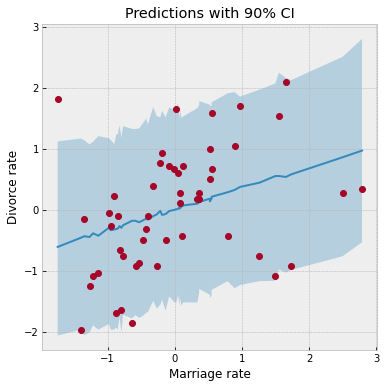

In [13]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

plot_regression以前と同じ機能を使用しました。sigmaパラメータによって追加のノイズが導入されたため、予測分布のCIが最後のプロットと比較してはるかに広いことがわかります。ほとんどのデータポイントは90％CI内に十分にあり、これは適切であることを示しています。

事後予測密度
同様に、エフェクトハンドラーとを使用してvmap、データセットが与えられた場合のこのモデルの対数尤度、およびによって与えられる対数事後予測密度[ 6 ]を 計算することもできます。
l o g∏i = 1n∫p （y私| θ）pp o s t（θ ）dθ ≈∑i = 1nl o g∑sp （θs）。S=∑i = 1n（l o g∑sp （θs）− l o g（S））
。

ここに、 私 観測されたデータポイントにインデックスを付けます y そして s 潜在パラメータの後方サンプルにインデックスを付けます θ。モデルの事後予測密度の値が比較的高い場合は、特定のモデルで観測されたデータポイントの確率が高いことを示しています。

### 事後予測密度
同様に、エフェクトハンドラーとを使用してvmap、データセットが与えられた場合のこのモデルの対数尤度、およびによって与えられる対数事後予測密度[ 6 ]を 計算することもできます。
l o g∏i = 1n∫p （y私| θ）pp o s t（θ ）dθ ≈∑i = 1nl o g∑sp （θs）。S=∑i = 1n（l o g∑sp （θs）− l o g（S））
。

ここに、 私 観測されたデータポイントにインデックスを付けます y そして s 潜在パラメータの後方サンプルにインデックスを付けます θ。モデルの事後予測密度の値が比較的高い場合は、特定のモデルで観測されたデータポイントの確率が高いことを示しています。

In [14]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])
    
def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

NumPyroは、一般的なモデルの最初の関数と同様に、計算に直接使用できるlog_likelihoodユーティリティ関数を提供することに注意してくださいlog likelihood。このチュートリアルでは、このようなユーティリティ関数には魔法のようなものはなく、NumPyroのエフェクト処理スタックを使用して独自の推論ユーティリティを展開できることを強調したいと思います。

In [15]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                                     samples_1, 
                                                                     model,
                                                                     marriage=dset.MarriageScaled.values,
                                                                     divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -66.71275329589844


### モデル2：予測子-結婚年齢の中央値
ここで、離婚率を結婚年齢の中央値の関数としてモデル化します。計算は主に、モデル1で行ったことを再現したものです。次の点に注意してください。

離婚率は結婚年齢に反比例します。したがって、結婚年齢の中央値が低い州では、離婚率が高くなる可能性があります。
モデル2と比較して、対数尤度が高くなります。これは、結婚年齢の中央値が離婚率のはるかに優れた予測因子である可能性が高いことを示しています。

In [16]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████████████████████████████████| 3000/3000 [00:02<00:00, 1450.66it/s, 7 steps of size 7.14e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.18      0.15   1768.15      1.00
        bA     -0.57      0.11     -0.56     -0.75     -0.38   1664.55      1.00
     sigma      0.82      0.08      0.82      0.68      0.94   1864.74      1.00

Number of divergences: 0


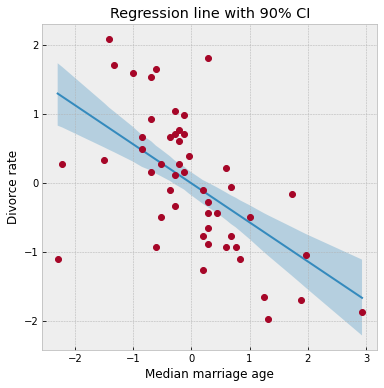

In [17]:
posterior_mu = jnp.expand_dims(samples_2['a'], -1) + \
               jnp.expand_dims(samples_2['bA'], -1) * dset.AgeScaled.values
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Median marriage age', ylabel='Divorce rate', title='Regression line with 90% CI');

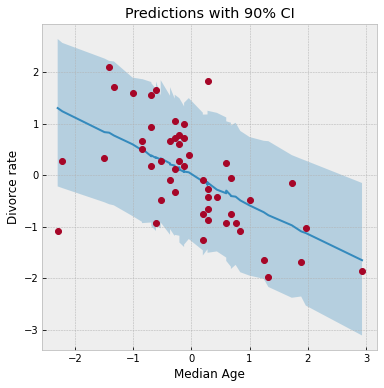

In [18]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2)(rng_key_,
                                             age=dset.AgeScaled.values)['obs']

mean_pred = jnp.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Median Age', ylabel='Divorce rate', title='Predictions with 90% CI');

In [19]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                    samples_2, 
                                                    model,
                                                    age=dset.AgeScaled.values,
                                                    divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -59.23302459716797


### モデル3：予測子-結婚率と結婚年齢の中央値
最後に、離婚率も結婚率と結婚年齢の中央値の両方に応じてモデル化します。モデルの事後予測密度はモデル2に類似していることに注意してください。これは、結婚年齢の中央値がすでにわかっている場合、離婚率を予測する際の結婚率からの限界情報が低いことを示している可能性があります。

In [20]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, marriage=dset.MarriageScaled.values,
         age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████████████████████████████████| 3000/3000 [00:02<00:00, 1311.47it/s, 7 steps of size 5.75e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.17      0.15   1723.43      1.00
        bA     -0.62      0.16     -0.62     -0.89     -0.35   1493.73      1.00
        bM     -0.07      0.16     -0.07     -0.34      0.19   1490.38      1.00
     sigma      0.83      0.08      0.82      0.70      0.96   1608.89      1.00

Number of divergences: 0


In [21]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(
    log_pred_density(rng_key_,
                     samples_3,
                     model,
                     marriage=dset.MarriageScaled.values,
                     age=dset.AgeScaled.values,
                     divorce=dset.DivorceScaled.values)
))

Log posterior predictive density: -59.03802490234375


### 州別の離婚率の残差
上記の回帰プロットは、多くの州で観測された離婚率が平均回帰直線とはかなり異なることを示しています。最後のモデル（モデル3）が各状態についてどのように過小予測または過大予測するかをより深く掘り下げるために、各状態の事後予測と残差（Observed divorce rate - Predicted divorce rate）をプロットします。

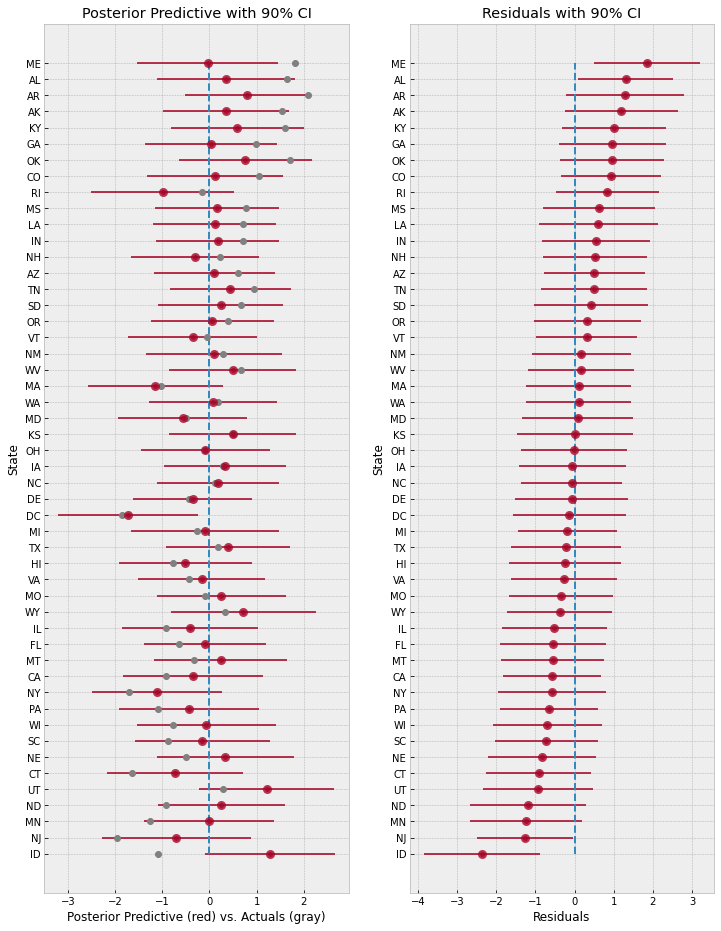

In [22]:
# Predictions for Model 3.
rng_key, rng_key_ = random.split(rng_key)
predictions_3 = Predictive(model, samples_3)(rng_key_,
                                             marriage=dset.MarriageScaled.values,
                                             age=dset.AgeScaled.values)['obs']
y = jnp.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = jnp.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = jnp.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(jnp.zeros(50), y, '--')
ax[0].errorbar(pred_mean[idx], y, xerr=pred_hpdi[1, idx] - pred_mean[idx], 
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker='o', 
           ls='none', color='gray')
ax[0].set(xlabel='Posterior Predictive (red) vs. Actuals (gray)', ylabel='State', 
          title='Posterior Predictive with 90% CI')
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10);

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(jnp.zeros(50), y, '--')
ax[1].errorbar(residuals_mean[idx], y, xerr=err[idx], 
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[1].set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);

左側のプロットは、モデル3を使用した各州の90％CIでの平均予測を示しています。灰色のマーカーは、実際に観測された離婚率を示しています。右のプロットは各状態の残差を示しており、これらのプロットは両方とも残差でソートされています。つまり、下部では、モデルの予測が観測されたレートよりも高い状態を示していますが、上部では逆です。本当です。

全体として、モデルの適合は良好であるように見えます。これは、ほとんどの観測データポイントが、平均予測の周囲の90％CI以内にあるためです。ただし、モデルがアイダホ州（左下）のような州では大幅に過大予測し、メイン州（右上）のような州では過小予測していることに注意してください。これは、さまざまな州の離婚率に影響を与える、モデルで見逃している他の要因を示している可能性があります。他の社会政治的変数を無視しても、まだモデル化していないそのような要因の1つDivorce SEは、データセットで与えられた測定ノイズです。これについては、次のセクションで説明します。

### 測定誤差のある回帰モデル
以前のモデルでは、各データポイントが回帰直線に等しく影響することに注意してください。これは十分に正当化されていますか？以前のモデルに基づいて、Divorce SE変数によって与えられた測定誤差をデータセットに組み込みます。測定ノイズを組み込むことは、信頼性が高い（つまり、測定ノイズが低い）観測値が回帰直線に大きな影響を与えることを保証するのに役立ちます。一方、これは、測定誤差の大きい外れ​​値をより適切にモデル化するのにも役立ちます。測定ノイズによるモデリングエラーの詳細については、[ 1 ]の第14章を参照してください。

これを行うには、モデル3を再利用しますが、最終的な観測値の測定誤差がによって与えられるという変更のみがありますdivorce_sd（divorce変数自体が0とstd 1を意味するように標準化されているため、これを標準化する必要があることに注意してください）。

In [23]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    bM = numpyro.sample('bM', dist.Normal(0., 0.5))
    M = bM * marriage
    bA = numpyro.sample('bA', dist.Normal(0., 0.5))
    A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    divorce_rate = numpyro.sample('divorce_rate', dist.Normal(mu, sigma))
    numpyro.sample('obs', dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [24]:
# Standardize
dset['DivorceScaledSD'] = dset['Divorce SE'] / jnp.std(dset.Divorce.values)

In [25]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_se, target_accept_prob=0.9)                                                         
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values,
         divorce_sd=dset.DivorceScaledSD.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_4 = mcmc.get_samples()

sample: 100%|█████████████████████████████████████| 4000/4000 [00:03<00:00, 1157.36it/s, 15 steps of size 2.67e-01. acc. prob=0.94]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
               a     -0.05      0.10     -0.06     -0.21      0.10   2475.85      1.00
              bA     -0.61      0.16     -0.62     -0.89     -0.36   1913.28      1.00
              bM      0.06      0.17      0.05     -0.21      0.33   1691.50      1.00
 divorce_rate[0]      1.16      0.38      1.16      0.58      1.82   3233.24      1.00
 divorce_rate[1]      0.69      0.55      0.68     -0.17      1.64   4188.56      1.00
 divorce_rate[2]      0.43      0.35      0.43     -0.11      1.01   4992.11      1.00
 divorce_rate[3]      1.41      0.45      1.40      0.70      2.16   3951.86      1.00
 divorce_rate[4]     -0.90      0.13     -0.90     -1.12     -0.69   6471.87      1.00
 divorce_rate[5]      0.65      0.41      0.65     -0.03      1.29   4627.47      1.00
 divorce_rate[6]     -1.37      0.36     -1.36     -1.92     -0.76   4737.53      1.00
 divorce_rate[7]     -0.33      0.49     -

### 残留物に対する測定ノイズの組み込みの影響

回帰係数の値はモデル3と非常に似ていることに注意してください。ただし、測定ノイズを導入すると、予測分布を観測値により厳密に一致させることができます。以前のように残差をプロットすると、これを確認できます。

In [26]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model_se, samples_4)(rng_key_,
                                                marriage=dset.MarriageScaled.values,
                                                age=dset.AgeScaled.values,
                                                divorce_sd=dset.DivorceScaledSD.values)['obs']

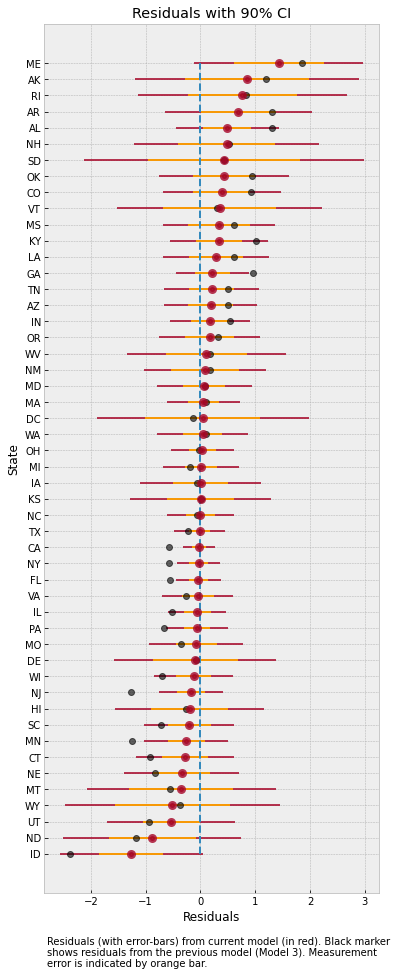

In [27]:
sd = dset.DivorceScaledSD.values
residuals_4 = dset.DivorceScaled.values - predictions_4
residuals_mean = jnp.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = jnp.argsort(residuals_mean)
y = jnp.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(jnp.zeros(50), y, '--')
ax.errorbar(residuals_mean[idx], y, xerr=err[idx], 
            marker='o', ms=5, mew=4, ls='none', alpha=0.8)

# Plot SD 
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], 
            ls='none', color='orange', alpha=0.9)

# Plot earlier mean residual
ax.plot(jnp.mean(dset.DivorceScaled.values - predictions_3, 0)[idx], y,
        ls='none', marker='o', ms=6, color='black', alpha=0.6)

ax.set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10);
ax.text(-2.8, -7, 'Residuals (with error-bars) from current model (in red). '
                  'Black marker \nshows residuals from the previous model (Model 3). '
                  'Measurement \nerror is indicated by orange bar.');

上のプロットは、各状態の残差と、内部エラーバーによって与えられる測定ノイズを示しています。灰色の点は、以前のモデル3の平均残差です。測定ノイズをモデル化するための追加の自由度があると、残差がどのように縮小したかに注目してください。特に、アイダホ州とメイン州では、モデルに測定ノイズを組み込んだ後、予測が観測値にはるかに近くなりました。

測定ノイズが回帰直線の動きにどのように影響するかをよりよく理解するために、測定ノイズに関して残差をプロットしてみましょう。

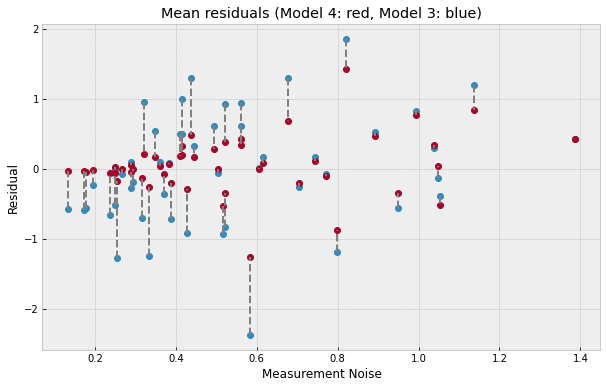

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = dset.DivorceScaledSD.values
y1 = jnp.mean(residuals_3, 0)
y2 = jnp.mean(residuals_4, 0)
ax.plot(x, y1, ls='none', marker='o')
ax.plot(x, y2, ls='none', marker='o')
for i, (j, k)  in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], '--', color='gray');

ax.set(xlabel='Measurement Noise', ylabel='Residual', title='Mean residuals (Model 4: red, Model 3: blue)');

上のプロットは、何が起こったかをより詳細に示しています。回帰直線自体が移動して、残差が0に非常に近く縮小した、測定ノイズの低い観測（プロットの左側）により適したものになっています。つまり、データ測定誤差が小さい点は、同時に回帰直線の決定に大きく貢献します。一方、測定誤差が大きい状態（プロットの右側）の場合、測定ノイズを組み込むと、事後分布の質量を観測値に近づけることができ、残差も縮小します。